# Passive Tracers

In [ ]:
from underworld import UWGeodynamics as GEO
from underworld import visualisation as vis

In [2]:
u = GEO.UnitRegistry

## Scaling

In [3]:
half_rate = 12.0 * u.centimeter / u.year
model_length = 200e3 * u.meter
bodyforce = 3300 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

# Geometry

In [4]:
Model = GEO.Model(elementRes=(128, 64), 
                  minCoord=(0. * u.kilometer, -50. * u.kilometer), 
                  maxCoord=(200. * u.kilometer, 50. * u.kilometer), 
                  gravity=(0.0, -10 * u.meter / u.second**2))

	Global element size: 128x64
	Local offset of rank 0: 0x0
	Local range of rank 0: 128x64
In func WeightsCalculator_CalculateAll(): for swarm "SKJKJ51G__swarm"
	done 33% (2731 cells)...
	done 67% (5462 cells)...
	done 100% (8192 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "SKJKJ51G__swarm"


In [5]:
material1 = Model.add_material(name="Material 1", shape=GEO.shapes.Layer(top=Model.top, bottom=0.))
material2 = Model.add_material(name="Material 2", shape=GEO.shapes.Layer(top=0., bottom=Model.bottom))

In [6]:
material1.density = 1000. * u.kilogram / u.metre**3
material2.density = 3000. * u.kilogram / u.metre**3

# Viscosities

In [7]:
Model.minViscosity = 1e18 * u.pascal * u.second
Model.maxViscosity = 1e23 * u.pascal * u.second

material1.viscosity = 1e19 * u.pascal * u.second
material2.viscosity = 1e20 * u.pascal * u.second

## Velocity Boundary Conditions

In [8]:
Model.set_velocityBCs(left=[-2.0 * u.centimeter / u.year, None],
                      right=[2.0 * u.centimeter / u.year, None],
                      bottom=[None, 0.])

# Passive Tracers

### Single tracer

We create a single tracer that we place at the surface, in a central position. 

In [9]:
import numpy as np

vertices = np.ndarray((1, 2))
vertices[:, 0] = GEO.nd((Model.maxCoord[0] - Model.minCoord[0]) / 2.0)
vertices[:, 1] = 0.

Model.add_passive_tracers(name="central", vertices=vertices)

### Interface tracers

We add 2 sets of tracers for tracking the interface at the surface and the moho.

In [10]:
import numpy as np

npoints = 1000

coords = np.ndarray((npoints, 2))
coords[:, 0] = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), npoints)
coords[:, 1] = 0.

Model.add_passive_tracers(name="interface_1", vertices=coords)

coords[:, 1] = -GEO.nd(20.*u.kilometres)
Model.add_passive_tracers(name="interface_2", vertices=coords)


### Grid Tracers

In [11]:
pts = GEO.circles_grid(radius=2.0*u.kilometer, 
                       minCoord=[Model.minCoord[0], -20.*u.kilometer], 
                       maxCoord=[Model.maxCoord[0], 0.*u.kilometer])

Model.add_passive_tracers(name="grid", vertices=pts)


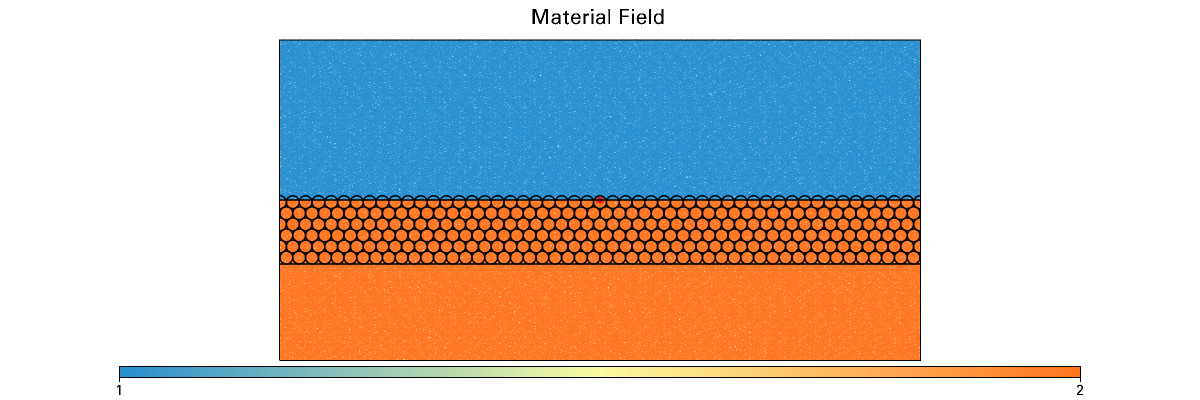

In [12]:
Fig = vis.Figure(figsize=(1200,400), title="Material Field", quality=2)
Fig.Points(Model.interface_1_tracers, pointSize=2.0)
Fig.Points(Model.interface_2_tracers, pointSize=2.0)
Fig.Points(Model.grid_tracers, pointSize=2.0)
Fig.Points(Model.central_tracers, pointSize=10.0, colour="red")
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.show()

# Tracked Fields

In [13]:
Model.interface_2_tracers.add_tracked_field(Model.pressureField,
                                            name="Pressure",
                                            units=u.pascal, 
                                            dataType="double",
                                            count=1)

Model.interface_2_tracers.add_tracked_field(Model.viscosityField,
                                            name="Viscosity",
                                            units=u.pascal / u.second, 
                                            dataType="double",
                                            count=1)

# Compute initial condition

In [ ]:
Model.init_model()


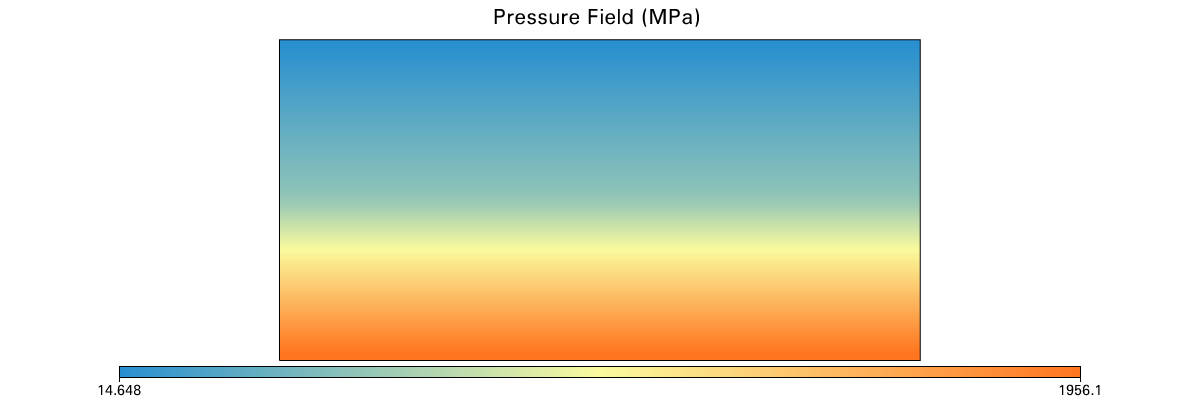

In [15]:
Fig = vis.Figure(figsize=(1200,400), title="Pressure Field (MPa)", quality=3)
Fig.Surface(Model.mesh, GEO.dimensionalise(Model.pressureField, u.megapascal))
Fig.show()

## Solver options

In [16]:
Model.solver.set_inner_method("mumps")
Model.solver.set_penalty(1e6)
GEO.rcParams["initial.nonlinear.tolerance"] = 1e-4

# Run the Model

In [17]:
Model.run_for(nstep=2, checkpoint_interval=1)

Running with UWGeodynamics version 2.13.0-dev-a52c2bc(pt-restart)
Options:  -Q22_pc_type gkgdiag -force_correction True -ksp_type bsscr -pc_type none -ksp_k2_type NULL -rescale_equations False -remove_constant_pressure_null_space False -change_backsolve False -change_A11rhspresolve False -restore_K False -A11_ksp_type preonly -A11_pc_type lu -A11_pc_factor_mat_solver_type mumps -scr_ksp_type fgmres -scr_ksp_rtol 1e-05 -A11_mg_active False
Linear solver (1GYRKR28__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.029028 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.004839 secs / 1 its
  Pressure Solve:         = 0.01674 secs / 3 its
  Final V Solve:          = 0.004398 secs / 1 its

  Total BSSCR Linear solve time: 0.256739 seconds

Linear solver (1GYRKR28__system-execute), solution time 2.602456e-01 (secs)
Ti

1


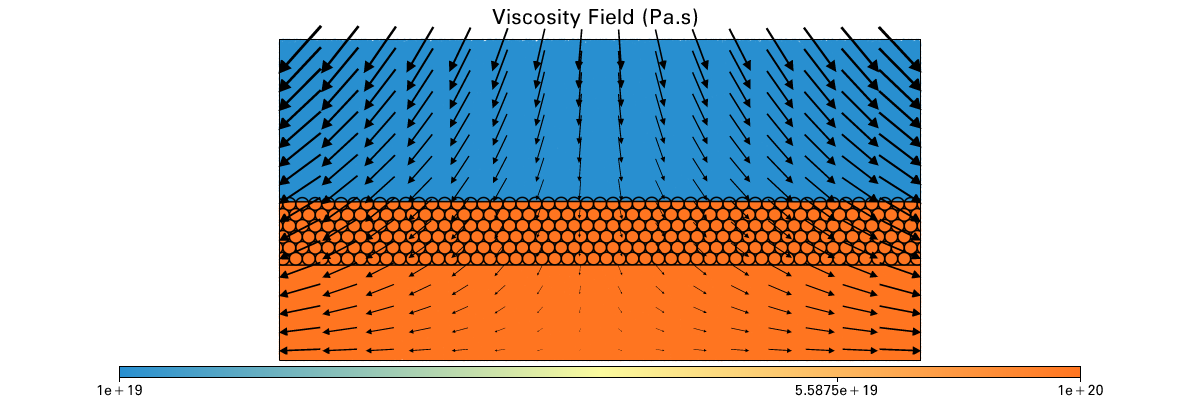

In [18]:
Fig = vis.Figure(figsize=(1200,400), title="Viscosity Field (Pa.s)", quality=3)
Fig.Points(Model.interface_1_tracers, pointSize=2.0)
Fig.Points(Model.interface_2_tracers, pointSize=2.0)
Fig.Points(Model.grid_tracers, pointSize=2.0)
Fig.Points(Model.central_tracers, pointSize=2.0)
Fig.Points(Model.swarm, 
           GEO.dimensionalise(Model.viscosityField, u.pascal * u.second),
           logScale=True,
           fn_size=3.0)
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.show()

In [19]:
Model.interface_2_tracers.tracked_fields

{'pressure': {'units': <Unit('pascal')>,
  'value': <underworld.mesh._meshvariable.MeshVariable at 0x7fd517522370>,
  'count': 1,
  'dataType': 'double',
  'timeIntegration': False},
 'viscosity': {'units': <Unit('pascal / second')>,
  'value': <underworld.swarm._swarmvariable.SwarmVariable at 0x7fd5174c22e0>,
  'count': 1,
  'dataType': 'double',
  'timeIntegration': False}}

In [20]:
Model.interface_2_tracers.pressure.data[:10]

array([[ 0.17242948],
       [ 0.17242948],
       [ 0.17242948],
       [ 0.17242948],
       [ 0.17242948],
       [ 0.17242948],
       [ 0.17243984],
       [ 0.17243984],
       [ 0.17243984],
       [ 0.17243984]])

In [21]:
Model.interface_2_tracers.viscosity.data[:10]

array([[ 0.00029366],
       [ 0.00029366],
       [ 0.00029366],
       [ 0.00029366],
       [ 0.00029366],
       [ 0.00029366],
       [ 0.00029366],
       [ 0.00029366],
       [ 0.00029366],
       [ 0.00029366]])

In [22]:
Model.interface_2_tracers.global_index.data[:10]

array([[4243427688448],
       [4247722655744],
       [4252017623040],
       [4256312590336],
       [4260607557632],
       [4264902524928],
       [  25769803776],
       [  30064771072],
       [  34359738368],
       [  38654705664]])

In [23]:
Model.run_for(nstep=2, checkpoint_interval=1, restartStep=2)


Restarting Model from Step 2 at Time = 54037.64812456013 year

(2022-03-28 09:13:49)

Mesh loaded(2022-03-28 09:13:49)
Swarm loaded(2022-03-28 09:13:49)
In func WeightsCalculator_CalculateAll(): for swarm "0I5XUZQP__swarm"
	done 33% (2731 cells)...
	done 67% (5462 cells)...
	done 100% (8192 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "0I5XUZQP__swarm"
pressureField loaded(2022-03-28 09:13:50)
velocityField loaded(2022-03-28 09:13:50)
materialField loaded(2022-03-28 09:13:50)
plasticStrain loaded(2022-03-28 09:13:50)
meltField loaded(2022-03-28 09:13:51)
timeField loaded(2022-03-28 09:13:51)
temperature loaded(2022-03-28 09:13:51)
central loaded(2022-03-28 09:13:51)
interface_1 loaded(2022-03-28 09:13:51)
interface_2 loaded(2022-03-28 09:13:51)
grid loaded(2022-03-28 09:13:51)
Running with UWGeodynamics version 2.13.0-dev-a52c2bc(pt-restart)
Options:  -Q22_pc_type gkgdiag -force_correction True -ksp_type bsscr -pc_type none -ksp_k2_type GMG -rescale

1

In [24]:
Model.interface_2_tracers.tracked_fields

{'pressure': {'units': <Unit('pascal')>,
  'value': <underworld.mesh._meshvariable.MeshVariable at 0x7fd517522370>,
  'count': 1,
  'dataType': 'double',
  'timeIntegration': False},
 'viscosity': {'units': <Unit('pascal / second')>,
  'value': <underworld.swarm._swarmvariable.SwarmVariable at 0x7fd508181820>,
  'count': 1,
  'dataType': 'double',
  'timeIntegration': False}}

In [25]:
Model.interface_2_tracers.global_index.data[:10]

array([[4243427688448],
       [4200478015488],
       [4204772982784],
       [4217657884672],
       [4221952851968],
       [4226247819264],
       [4230542786560],
       [4234837753856],
       [4239132721152],
       [4209067950080]])